## Bolus Glucose Control in Type 1 Diabetes Using Deep Reinforcement Learning
Raphael Joost, 18-???-??? & Yanis Schärer, 18-114-058

### Implementing a Deep Deterministic Policy Gradient (DDPG) agent


In [1]:
import numpy as np
import torch as th
import torch.nn.functional as F
from copy import deepcopy
from datetime import datetime
import simglucose
import gym
from gym.wrappers import FlattenObservation
from tqdm import tqdm

C:\Users\yanis\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define Replay Buffer
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, device, max_size=500):
        self.device = device
        self.max_size = max_size
        self.size = 0
        self.ptr = 0
        self.state_buffer = np.zeros((max_size, state_dim))
        self.action_buffer = np.zeros((max_size, action_dim))
        self.next_state_buffer = np.zeros((max_size, state_dim))
        self.reward_buffer = np.zeros((max_size, 1))
        self.done_buffer = np.zeros((max_size, 1))

    def store(self, state, action, reward, next_state, done):
        self.state_buffer[self.ptr] = state
        self.action_buffer[self.ptr] = action
        self.next_state_buffer[self.ptr] = next_state
        self.reward_buffer[self.ptr] = reward
        self.done_buffer[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample(self, batch_size):
        idx = np.random.randint(0, self.size, size=batch_size)
        return (
            th.tensor(self.state_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.action_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.reward_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.next_state_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.done_buffer[idx], dtype=th.float32).to(self.device)
        )

In [3]:
# Define Actor and Critic networks
class Actor(th.nn.Module): # state -> action
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.l1 = th.nn.Linear(state_dim, 200)
        self.l2 = th.nn.Linear(200, 200)
        self.l3 = th.nn.Linear(200, 10)
        self.l4 = th.nn.Linear(10, action_dim)

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = F.relu(self.l3(a))
        a = th.sigmoid(self.l4(a))
        return 1.8 * a + 0.2 # scale to [0.2, 2.0]

class Critic(th.nn.Module): # state + action -> Q(s,a) (Q-Network)
    def __init__(self, state_dimension, action_dimension):
        super(Critic, self).__init__()
        self.l1 = th.nn.Linear(state_dimension + action_dimension, 200)
        self.l2 = th.nn.Linear(200, 200)
        self.l3 = th.nn.Linear(200, 10)
        self.l4 = th.nn.Linear(10, 1)

    def forward(self, state, action):
        q = F.relu(self.l1(th.cat([state, action], 1)))
        q = F.relu(self.l2(q))
        q = F.relu(self.l3(q))
        q = self.l4(q)
        return q

In [4]:
# Define DDPG Agent
class DDPGAgent(object):
    def __init__(self, env, device, discount=0.9, tau=0.01):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.device = device
        self.discount = discount
        self.tau = tau
        # Actor and Actor target
        self.actor = Actor(self.state_dim, self.action_dim).to(device)
        self.actor_optimizer = th.optim.Adam(self.actor.parameters(), lr=1e-4)
        self.actor_target = deepcopy(self.actor)
        # Critic and Critic target
        self.critic = Critic(self.state_dim, self.action_dim).to(device)
        self.critic_optimizer = th.optim.Adam(self.critic.parameters(), lr=1e-4)
        self.critic_target = deepcopy(self.critic)
        # Replay buffer
        self.replay_buffer = ReplayBuffer(self.state_dim, self.action_dim, self.device)

    def save(self, path):
        pass
        # th.save(self.actor.state_dict(), path + 'actor.pth')
        # th.save(self.critic.state_dict(), path + 'critic.pth')

    def soft_update(self):
        for target_param, local_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
        for target_param, local_param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def select_action(self, state): # Actor selects action based on current state
        return self.actor(th.tensor(state, dtype=th.float32).to(self.device)).detach().cpu().numpy()

    def train(self, batch_size=32, target_update_period=10, max_iter=1000, max_patience=50):
        CHO_idx = int(2*self.state_dim/3 - 1)
        critic_training_loss = []
        min_critic_loss = float('inf')
        patience = max_patience
        for it in tqdm(range(max_iter)):
            # Sample one episode and add it to the replay buffer
            state, info = self.env.reset()
            reset_time = info['time']
            done = False
            last_meal = state[CHO_idx] # XXX
            while not done and (info['time'] - reset_time).days < 4: # 4 days
                if last_meal > state[CHO_idx]: # First step after meal
                    print('Bolus Injection!')
                    start_state = state
                    start_time = info['time']
                    noise = np.random.normal(0, 0.3, (3,))
                    bolus_action = self.select_action(start_state) + noise
                    last_meal = state[CHO_idx] #### XXX
                    state, reward, done, _, info = self.env.step(bolus_action)
                    reward_sum = reward
                    while not done and state[CHO_idx] == 0 and (info['time'] - start_time).seconds < 5*3600:
                        action = [0, 0, 0]
                        last_meal = state[CHO_idx] #### XXX
                        state, reward, done, _, info = self.env.step(action)
                        reward_sum += reward
                    reward_sum /= (info['time'] - start_time).seconds / 60
                    next_state = state
                    self.replay_buffer.store(start_state, bolus_action, reward_sum, next_state, done)
                    print(f'Episode (reward: {reward_sum}) stored to memory ({self.replay_buffer.size})')
 
                else:
                    action = [0, 0, 0]
                    last_meal = state[CHO_idx] #### XXX
                    state, _, done, _, info = self.env.step(action)

                
            
            if self.replay_buffer.size >= batch_size:
                print('Training...')
                # Sample replay buffer
                states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
                # Compute the target Q value
                target_q = self.critic_target(next_states, self.actor_target(next_states))
                target_q = rewards + (self.discount * target_q).detach()
                # target_q = rewards + ((not dones) * self.discount * target_q).detach() # XXX: ?????????????
                # Get current Q estimate
                current_q = self.critic(states, actions)
                # Compute critic loss
                critic_loss = F.mse_loss(current_q, target_q)
                # Optimize the critic
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()
                # Compute actor loss
                actor_loss = -self.critic(states, self.actor(states)).mean()
                # Optimize the actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
                # Save training loss   
                if critic_loss < min_critic_loss:
                    min_critic_loss = critic_loss
                    patience = max_patience
                critic_training_loss.append([critic_loss.item(), actor_loss.item()])
                
                # Update target networks
                if it % target_update_period == 0:
                    self.soft_update()

                if it % 5 == 0:
                    print(f'Iteration: {it+1}, Critic loss: {critic_loss.item():.3f} (min: {min_critic_loss:.3f}), Patience left: {patience}')

                # Convergence check
                patience -= 1
                if patience == 0:
                    print('Critic converged...')
                    break

        return critic_training_loss

    def finetune():
        pass

In [5]:
# Define reward function based on paper
def custom_reward(BG_history):
    BG = BG_history[-1]
    # BG: blood glucose level
    # Hypoglycemia: BG < 70 mg/dL
    if 30 <= BG and BG < 70:
        return -1.5
    # Normoglycemia: 70 mg/dL < BG < 180 mg/dL
    elif 70 <= BG and BG <= 180:
        return 0.5
    # Hyperglycemia: BG > 180 mg/dL
    elif 180 < BG and BG <= 300:
        return -0.8
    elif 300 < BG and BG <= 350:
        return -1
    # Other cases
    else:
        return -2

### Linking the DDPG agent to the OpenAI Gym environment

In [6]:
from simglucose.simulation.scenario_gen import RandomScenario

history_length = 6

gym.envs.register(
    id='simglucose-bolus',
    entry_point='simglucose.envs:T1DSimEnvBolus',
    kwargs={'patient_name': ['average_adolescent'],
        'history_length': history_length, 'reward_fun': custom_reward,
        'enable_meal': True})

In [7]:
env = gym.make('simglucose-bolus')
print(env.observation_space)
print(env.action_space)

Dict('CGM': Box(0.0, 10000.0, (6,), float32), 'CHO': Box(0.0, 10000.0, (6,), float32), 'insulin': Box(0.0, 10000.0, (6,), float32))
Box(0.2, 2.0, (3,), float32)


In [8]:
env = FlattenObservation(env)

In [9]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

agent = DDPGAgent(env=env, device=device)
critic_loss = agent.train()

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\yanis\anaconda3\envs\simgl\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Bolus Injection!
Episode (reward: -0.06466666666666672) stored to memory (1)
Bolus Injection!
Episode (reward: -0.05733333333333334) stored to memory (2)
Bolus Injection!
Episode (reward: -0.03333333333333334) stored to memory (3)
Bolus Injection!
Episode (reward: -0.033999999999999996) stored to memory (4)
Bolus Injection!
Episode (reward: -0.02100000000000004) stored to memory (5)
Bolus Injection!
Episode (reward: 0.004999999999999988) stored to memory (6)
Bolus Injection!
Episode (reward: -0.10966666666666666) stored to memory (7)
Bolus Injection!
Episode (reward: -0.10833333333333335) stored to memory (8)
Bolus Injection!
Episode (reward: 0.12733333333333335) stored to memory (9)
Bolus Injection!
Episode (reward: -0.10400000000000001) stored to memory (10)
Bolus Injection!


  0%|          | 1/1000 [00:36<10:12:11, 36.77s/it]

Episode (reward: -0.05277777777777779) stored to memory (11)
Bolus Injection!
Episode (reward: -0.061333333333333365) stored to memory (12)
Bolus Injection!
Episode (reward: -0.0056666666666667) stored to memory (13)
Bolus Injection!
Episode (reward: -0.09833333333333336) stored to memory (14)
Bolus Injection!
Episode (reward: -0.022666666666666675) stored to memory (15)
Bolus Injection!
Episode (reward: 0.053999999999999986) stored to memory (16)
Bolus Injection!
Episode (reward: -0.014666666666666685) stored to memory (17)
Bolus Injection!
Episode (reward: -0.044666666666666674) stored to memory (18)
Bolus Injection!
Episode (reward: -0.059333333333333356) stored to memory (19)
Bolus Injection!
Episode (reward: -0.06400000000000002) stored to memory (20)
Bolus Injection!
Episode (reward: 0.07966666666666666) stored to memory (21)
Bolus Injection!
Episode (reward: 0.06266666666666666) stored to memory (22)
Bolus Injection!


  0%|          | 2/1000 [01:27<12:26:54, 44.90s/it]

Episode (reward: -0.07433333333333338) stored to memory (23)
Bolus Injection!
Episode (reward: -0.10333333333333337) stored to memory (24)
Bolus Injection!
Episode (reward: 0.008333333333333286) stored to memory (25)
Bolus Injection!


  0%|          | 3/1000 [01:53<10:01:50, 36.22s/it]

Episode (reward: -0.059722222222222246) stored to memory (26)
Bolus Injection!
Episode (reward: -0.051666666666666715) stored to memory (27)
Bolus Injection!
Episode (reward: -0.09733333333333336) stored to memory (28)
Bolus Injection!
Episode (reward: -0.024000000000000056) stored to memory (29)
Bolus Injection!
Episode (reward: -0.12366666666666654) stored to memory (30)
Bolus Injection!
Episode (reward: 0.03666666666666663) stored to memory (31)
Bolus Injection!
Episode (reward: -0.05933333333333335) stored to memory (32)
Bolus Injection!
Episode (reward: 0.02199999999999998) stored to memory (33)
Bolus Injection!
Episode (reward: -0.028333333333333346) stored to memory (34)
Bolus Injection!
Episode (reward: 0.014999999999999965) stored to memory (35)
Bolus Injection!
Episode (reward: 0.073) stored to memory (36)
Bolus Injection!
Episode (reward: 0.04099999999999997) stored to memory (37)
Bolus Injection!


  0%|          | 4/1000 [03:36<17:23:07, 62.84s/it]

Episode (reward: -0.02233333333333339) stored to memory (38)
Training...
Bolus Injection!


  0%|          | 5/1000 [03:47<12:09:00, 43.96s/it]

Episode (reward: -0.13233333333333336) stored to memory (39)
Training...
Bolus Injection!
Episode (reward: 0.014999999999999953) stored to memory (40)
Bolus Injection!


  1%|          | 6/1000 [04:03<9:32:01, 34.53s/it] 

Episode (reward: -0.08800000000000002) stored to memory (41)
Training...
Iteration: 6, Critic loss: 0.211 (min: 0.091), Patience left: 49
Bolus Injection!
Episode (reward: -0.07800000000000006) stored to memory (42)
Bolus Injection!
Episode (reward: -0.009666666666666709) stored to memory (43)
Bolus Injection!
Episode (reward: -0.05433333333333337) stored to memory (44)
Bolus Injection!
Episode (reward: -0.09533333333333335) stored to memory (45)
Bolus Injection!
Episode (reward: 0.04266666666666666) stored to memory (46)
Bolus Injection!
Episode (reward: 0.015999999999999983) stored to memory (47)
Bolus Injection!
Episode (reward: 0.03333333333333333) stored to memory (48)
Bolus Injection!
Episode (reward: -0.04300000000000003) stored to memory (49)
Bolus Injection!
Episode (reward: -0.0979999999999999) stored to memory (50)
Bolus Injection!
Episode (reward: -0.03300000000000002) stored to memory (51)
Bolus Injection!
Episode (reward: -0.06866666666666667) stored to memory (52)


  1%|          | 7/1000 [05:37<14:53:55, 54.01s/it]

Training...
Bolus Injection!
Episode (reward: -0.0726666666666667) stored to memory (53)
Bolus Injection!
Episode (reward: -0.04600000000000003) stored to memory (54)
Bolus Injection!
Episode (reward: -0.11300000000000002) stored to memory (55)
Bolus Injection!
Episode (reward: 0.013999999999999974) stored to memory (56)
Bolus Injection!


  1%|          | 8/1000 [06:20<13:53:52, 50.44s/it]

Episode (reward: -0.08581560283687946) stored to memory (57)
Training...
Bolus Injection!
Episode (reward: -0.1076666666666667) stored to memory (58)
Bolus Injection!
Episode (reward: 0.04966666666666664) stored to memory (59)
Bolus Injection!


  1%|          | 9/1000 [06:46<11:48:06, 42.87s/it]

Episode (reward: -0.07074829931972791) stored to memory (60)
Training...
Bolus Injection!


  1%|          | 10/1000 [06:54<8:46:05, 31.88s/it]

Episode (reward: -0.07644927536231887) stored to memory (61)
Training...
Bolus Injection!
Episode (reward: 0.0019999999999999454) stored to memory (62)
Bolus Injection!
Episode (reward: -0.024000000000000014) stored to memory (63)
Bolus Injection!
Episode (reward: -0.03700000000000002) stored to memory (64)
Bolus Injection!
Episode (reward: -0.10633333333333324) stored to memory (65)
Bolus Injection!
Episode (reward: -0.03133333333333339) stored to memory (66)
Bolus Injection!
Episode (reward: 0.014999999999999965) stored to memory (67)
Bolus Injection!
Episode (reward: -0.010666666666666687) stored to memory (68)
Bolus Injection!
Episode (reward: -0.02233333333333339) stored to memory (69)
Bolus Injection!
Episode (reward: -0.11500000000000002) stored to memory (70)
Bolus Injection!
Episode (reward: 0.05133333333333333) stored to memory (71)
Bolus Injection!
Episode (reward: -0.09999999999999991) stored to memory (72)
Bolus Injection!
Episode (reward: -0.10633333333333321) stored to m

  1%|          | 11/1000 [08:25<13:46:04, 50.12s/it]

Training...
Iteration: 11, Critic loss: 0.060 (min: 0.058), Patience left: 49
Bolus Injection!
Episode (reward: 0.010666666666666618) stored to memory (74)
Bolus Injection!
Episode (reward: -0.005666666666666688) stored to memory (75)
Bolus Injection!
Episode (reward: -0.04700000000000001) stored to memory (76)
Bolus Injection!
Episode (reward: -0.01966666666666673) stored to memory (77)
Bolus Injection!
Episode (reward: -0.038666666666666696) stored to memory (78)


  1%|          | 12/1000 [09:03<12:46:00, 46.52s/it]

Training...
Bolus Injection!


  1%|▏         | 13/1000 [09:08<9:16:48, 33.85s/it] 

Episode (reward: -0.15111111111111108) stored to memory (79)
Training...
Bolus Injection!
Episode (reward: -0.22333333333333297) stored to memory (80)
Bolus Injection!
Episode (reward: -0.006666666666666726) stored to memory (81)
Bolus Injection!
Episode (reward: 0.038333333333333316) stored to memory (82)
Bolus Injection!
Episode (reward: -0.010666666666666687) stored to memory (83)
Bolus Injection!
Episode (reward: -0.01933333333333336) stored to memory (84)
Bolus Injection!
Episode (reward: -0.0856666666666667) stored to memory (85)
Bolus Injection!
Episode (reward: -0.0463333333333334) stored to memory (86)
Bolus Injection!
Episode (reward: -0.18333333333333304) stored to memory (87)
Bolus Injection!
Episode (reward: -0.09333333333333324) stored to memory (88)
Bolus Injection!
Episode (reward: 0.011999999999999969) stored to memory (89)
Bolus Injection!
Episode (reward: -0.01100000000000005) stored to memory (90)
Bolus Injection!


  1%|▏         | 14/1000 [10:43<14:18:31, 52.24s/it]

Episode (reward: -0.08600000000000002) stored to memory (91)
Training...
Bolus Injection!
Episode (reward: -0.012333333333333366) stored to memory (92)
Bolus Injection!
Episode (reward: -0.14966666666666645) stored to memory (93)
Bolus Injection!


  2%|▏         | 15/1000 [11:07<11:59:34, 43.83s/it]

Episode (reward: -0.10833333333333334) stored to memory (94)
Training...
Bolus Injection!


  2%|▏         | 16/1000 [11:13<8:51:12, 32.39s/it] 

Episode (reward: -0.1526315789473684) stored to memory (95)
Training...
Iteration: 16, Critic loss: 0.061 (min: 0.023), Patience left: 48
Bolus Injection!
Episode (reward: -0.10633333333333321) stored to memory (96)
Bolus Injection!
Episode (reward: -0.16266666666666643) stored to memory (97)
Bolus Injection!
Episode (reward: -0.16733333333333308) stored to memory (98)
Bolus Injection!
Episode (reward: -0.08899999999999991) stored to memory (99)
Bolus Injection!
Episode (reward: -0.03200000000000004) stored to memory (100)
Bolus Injection!
Episode (reward: -0.06933333333333333) stored to memory (101)
Bolus Injection!
Episode (reward: -0.1366666666666665) stored to memory (102)
Bolus Injection!


  2%|▏         | 17/1000 [12:14<11:10:11, 40.91s/it]

Episode (reward: -0.11372549019607843) stored to memory (103)
Training...
Bolus Injection!
Episode (reward: -0.17399999999999974) stored to memory (104)
Bolus Injection!
Episode (reward: -0.054333333333333345) stored to memory (105)
Bolus Injection!
Episode (reward: 0.01933333333333329) stored to memory (106)
Bolus Injection!
Episode (reward: -0.1716666666666664) stored to memory (107)
Bolus Injection!
Episode (reward: -0.10199999999999988) stored to memory (108)
Bolus Injection!


  2%|▏         | 18/1000 [12:59<11:33:26, 42.37s/it]

Episode (reward: -0.07708333333333334) stored to memory (109)
Training...
Bolus Injection!


  2%|▏         | 19/1000 [13:05<8:32:27, 31.34s/it] 

Episode (reward: -0.17407407407407405) stored to memory (110)
Training...
Bolus Injection!


  2%|▏         | 20/1000 [13:08<6:12:37, 22.81s/it]

Episode (reward: -0.1333333333333333) stored to memory (111)
Training...
Bolus Injection!


  2%|▏         | 21/1000 [13:12<4:39:08, 17.11s/it]

Episode (reward: -0.15098039215686274) stored to memory (112)
Training...
Iteration: 21, Critic loss: 0.061 (min: 0.023), Patience left: 43
Bolus Injection!
Episode (reward: -0.1929999999999997) stored to memory (113)
Bolus Injection!


  2%|▏         | 22/1000 [13:21<4:00:07, 14.73s/it]

Episode (reward: -0.08095238095238096) stored to memory (114)
Training...
Bolus Injection!


  2%|▏         | 23/1000 [13:24<3:03:41, 11.28s/it]

Episode (reward: -0.13125) stored to memory (115)
Training...
Bolus Injection!
Episode (reward: -0.11933333333333318) stored to memory (116)
Bolus Injection!


  2%|▏         | 24/1000 [13:39<3:20:35, 12.33s/it]

Episode (reward: -0.08125) stored to memory (117)
Training...
Bolus Injection!
Episode (reward: -0.16266666666666643) stored to memory (118)
Bolus Injection!


  2%|▎         | 25/1000 [13:52<3:22:59, 12.49s/it]

Episode (reward: -0.13541666666666666) stored to memory (119)
Training...
Bolus Injection!


  3%|▎         | 26/1000 [13:57<2:48:53, 10.40s/it]

Episode (reward: -0.1476190476190476) stored to memory (120)
Training...
Iteration: 26, Critic loss: 0.023 (min: 0.023), Patience left: 50
Bolus Injection!


  3%|▎         | 27/1000 [14:04<2:29:08,  9.20s/it]

Episode (reward: -0.13846153846153844) stored to memory (121)
Training...
Bolus Injection!


  3%|▎         | 28/1000 [14:09<2:09:15,  7.98s/it]

Episode (reward: -0.15111111111111108) stored to memory (122)
Training...
Bolus Injection!


  3%|▎         | 29/1000 [14:15<1:58:17,  7.31s/it]

Episode (reward: -0.1392156862745098) stored to memory (123)
Training...
Bolus Injection!
Episode (reward: -0.15399999999999978) stored to memory (124)
Bolus Injection!


  3%|▎         | 30/1000 [14:23<2:03:44,  7.65s/it]

Episode (reward: -0.11190476190476191) stored to memory (125)
Training...
Bolus Injection!


  3%|▎         | 31/1000 [14:27<1:44:30,  6.47s/it]

Episode (reward: -0.17037037037037037) stored to memory (126)
Training...
Iteration: 31, Critic loss: 0.043 (min: 0.023), Patience left: 45
Bolus Injection!


  3%|▎         | 32/1000 [14:29<1:24:00,  5.21s/it]

Episode (reward: -0.11190476190476191) stored to memory (127)
Training...
Bolus Injection!


  3%|▎         | 33/1000 [14:34<1:23:01,  5.15s/it]

Episode (reward: -0.15111111111111108) stored to memory (128)
Training...
Bolus Injection!


  3%|▎         | 34/1000 [14:37<1:09:51,  4.34s/it]

Episode (reward: -0.15238095238095237) stored to memory (129)
Training...
Bolus Injection!
Episode (reward: -0.21899999999999964) stored to memory (130)
Bolus Injection!


  4%|▎         | 35/1000 [14:47<1:39:11,  6.17s/it]

Episode (reward: -0.08095238095238096) stored to memory (131)
Training...
Bolus Injection!
Episode (reward: -0.21233333333333293) stored to memory (132)
Bolus Injection!


  4%|▎         | 36/1000 [14:58<2:01:28,  7.56s/it]

Episode (reward: -0.1) stored to memory (133)
Training...
Iteration: 36, Critic loss: 0.027 (min: 0.023), Patience left: 40
Bolus Injection!


  4%|▎         | 37/1000 [15:03<1:50:16,  6.87s/it]

Episode (reward: -0.12222222222222222) stored to memory (134)
Training...
Bolus Injection!


  4%|▍         | 38/1000 [15:07<1:36:02,  5.99s/it]

Episode (reward: -0.16470588235294115) stored to memory (135)
Training...
Bolus Injection!


  4%|▍         | 39/1000 [15:10<1:19:59,  4.99s/it]

Episode (reward: -0.15111111111111108) stored to memory (136)
Training...
Bolus Injection!


  4%|▍         | 40/1000 [15:16<1:26:01,  5.38s/it]

Episode (reward: -0.10416666666666667) stored to memory (137)
Training...
Bolus Injection!


  4%|▍         | 41/1000 [15:23<1:32:33,  5.79s/it]

Episode (reward: -0.08611111111111112) stored to memory (138)
Training...
Iteration: 41, Critic loss: 0.028 (min: 0.023), Patience left: 35
Bolus Injection!


  4%|▍         | 42/1000 [15:25<1:15:46,  4.75s/it]

Episode (reward: -0.08611111111111112) stored to memory (139)
Training...
Bolus Injection!
Episode (reward: -0.11933333333333318) stored to memory (140)
Bolus Injection!
Episode (reward: -0.2146666666666663) stored to memory (141)
Bolus Injection!


  4%|▍         | 43/1000 [15:46<2:35:18,  9.74s/it]

Episode (reward: -0.1333333333333333) stored to memory (142)
Training...
Bolus Injection!
Episode (reward: -0.21899999999999964) stored to memory (143)
Bolus Injection!


  4%|▍         | 44/1000 [15:56<2:36:17,  9.81s/it]

Episode (reward: -0.11190476190476191) stored to memory (144)
Training...
Bolus Injection!


  4%|▍         | 45/1000 [16:03<2:21:17,  8.88s/it]

Episode (reward: -0.08095238095238096) stored to memory (145)
Training...
Bolus Injection!


  5%|▍         | 46/1000 [16:07<1:55:49,  7.28s/it]

Episode (reward: -0.10416666666666667) stored to memory (146)
Training...
Iteration: 46, Critic loss: 0.039 (min: 0.019), Patience left: 49
Bolus Injection!


  5%|▍         | 47/1000 [16:12<1:45:37,  6.65s/it]

Episode (reward: -0.17777777777777778) stored to memory (147)
Training...
Bolus Injection!


  5%|▍         | 48/1000 [16:14<1:25:41,  5.40s/it]

Episode (reward: -0.18958333333333333) stored to memory (148)
Training...
Bolus Injection!


  5%|▍         | 49/1000 [16:18<1:15:22,  4.76s/it]

Episode (reward: -0.09333333333333334) stored to memory (149)
Training...
Bolus Injection!


  5%|▌         | 50/1000 [16:20<1:03:43,  4.02s/it]

Episode (reward: -0.1) stored to memory (150)
Training...
Bolus Injection!
Episode (reward: -0.20233333333333298) stored to memory (151)
Bolus Injection!


  5%|▌         | 51/1000 [16:32<1:44:08,  6.58s/it]

Episode (reward: -0.12222222222222222) stored to memory (152)
Training...
Iteration: 51, Critic loss: 0.052 (min: 0.019), Patience left: 44
Bolus Injection!
Episode (reward: -0.1583333333333331) stored to memory (153)
Bolus Injection!


  5%|▌         | 52/1000 [16:46<2:16:02,  8.61s/it]

Episode (reward: -0.1392156862745098) stored to memory (154)
Training...
Bolus Injection!
Episode (reward: -0.22766666666666627) stored to memory (155)
Bolus Injection!


  5%|▌         | 53/1000 [16:55<2:18:24,  8.77s/it]

Episode (reward: -0.1222222222222222) stored to memory (156)
Training...
Bolus Injection!
Episode (reward: -0.11933333333333321) stored to memory (157)
Bolus Injection!


  5%|▌         | 54/1000 [17:06<2:31:49,  9.63s/it]

Episode (reward: -0.09814814814814815) stored to memory (158)
Training...
Bolus Injection!
Episode (reward: -0.16699999999999973) stored to memory (159)
Bolus Injection!


  6%|▌         | 55/1000 [17:16<2:31:26,  9.61s/it]

Episode (reward: -0.13541666666666666) stored to memory (160)
Training...
Bolus Injection!
Episode (reward: -0.16699999999999973) stored to memory (161)
Bolus Injection!
Episode (reward: -0.23633333333333298) stored to memory (162)
Bolus Injection!


  6%|▌         | 56/1000 [17:34<3:10:07, 12.08s/it]

Episode (reward: -0.08611111111111112) stored to memory (163)
Training...
Iteration: 56, Critic loss: 0.032 (min: 0.019), Patience left: 39
Bolus Injection!


  6%|▌         | 57/1000 [17:36<2:23:16,  9.12s/it]

Episode (reward: -0.1333333333333333) stored to memory (164)
Training...
Bolus Injection!
Episode (reward: -0.12366666666666651) stored to memory (165)
Bolus Injection!


  6%|▌         | 58/1000 [17:49<2:39:34, 10.16s/it]

Episode (reward: -0.1368421052631579) stored to memory (166)
Training...
Bolus Injection!


  6%|▌         | 59/1000 [17:55<2:19:11,  8.87s/it]

Episode (reward: -0.15098039215686274) stored to memory (167)
Training...
Bolus Injection!
Episode (reward: -0.1583333333333331) stored to memory (168)
Bolus Injection!


  6%|▌         | 60/1000 [18:04<2:22:46,  9.11s/it]

Episode (reward: -0.10185185185185185) stored to memory (169)
Training...
Bolus Injection!


  6%|▌         | 61/1000 [18:11<2:09:24,  8.27s/it]

Episode (reward: -0.20185185185185187) stored to memory (170)
Training...
Iteration: 61, Critic loss: 0.033 (min: 0.019), Patience left: 34
Bolus Injection!


  6%|▌         | 62/1000 [18:17<1:59:58,  7.67s/it]

Episode (reward: -0.08095238095238096) stored to memory (171)
Training...
Bolus Injection!


  6%|▋         | 63/1000 [18:22<1:47:12,  6.86s/it]

Episode (reward: -0.11666666666666665) stored to memory (172)
Training...
Bolus Injection!


  6%|▋         | 64/1000 [18:28<1:45:11,  6.74s/it]

Episode (reward: -0.11190476190476191) stored to memory (173)
Training...
Bolus Injection!
Episode (reward: -0.1453333333333331) stored to memory (174)
Bolus Injection!


  6%|▋         | 65/1000 [18:44<2:25:33,  9.34s/it]

Episode (reward: -0.05) stored to memory (175)
Training...
Bolus Injection!
Episode (reward: -0.2506666666666662) stored to memory (176)
Bolus Injection!


  7%|▋         | 66/1000 [18:55<2:33:06,  9.84s/it]

Episode (reward: -0.15714285714285714) stored to memory (177)
Training...
Iteration: 66, Critic loss: 0.028 (min: 0.019), Patience left: 29
Bolus Injection!


  7%|▋         | 67/1000 [19:01<2:15:10,  8.69s/it]

Episode (reward: -0.15111111111111108) stored to memory (178)
Training...
Bolus Injection!


  7%|▋         | 68/1000 [19:08<2:07:48,  8.23s/it]

Episode (reward: -0.12666666666666668) stored to memory (179)
Training...
Bolus Injection!
Episode (reward: -0.1626666666666664) stored to memory (180)
Bolus Injection!


  7%|▋         | 69/1000 [19:19<2:20:00,  9.02s/it]

Episode (reward: -0.11372549019607843) stored to memory (181)
Training...
Bolus Injection!
Episode (reward: -0.24066666666666625) stored to memory (182)
Bolus Injection!


  7%|▋         | 70/1000 [19:34<2:48:09, 10.85s/it]

Episode (reward: -0.13846153846153844) stored to memory (183)
Training...
Bolus Injection!


  7%|▋         | 71/1000 [19:37<2:13:34,  8.63s/it]

Episode (reward: -0.20877192982456141) stored to memory (184)
Training...
Iteration: 71, Critic loss: 0.033 (min: 0.019), Patience left: 24
Bolus Injection!


  7%|▋         | 72/1000 [19:41<1:52:36,  7.28s/it]

Episode (reward: -0.16444444444444442) stored to memory (185)
Training...
Bolus Injection!
Episode (reward: -0.1799999999999997) stored to memory (186)
Bolus Injection!
Episode (reward: -0.24066666666666625) stored to memory (187)
Bolus Injection!


  7%|▋         | 73/1000 [20:03<2:56:31, 11.43s/it]

Episode (reward: -0.13846153846153844) stored to memory (188)
Training...
Bolus Injection!
Episode (reward: -0.010333333333333373) stored to memory (189)
Bolus Injection!
Episode (reward: -0.16699999999999976) stored to memory (190)
Bolus Injection!
Episode (reward: -0.24033333333333293) stored to memory (191)
Bolus Injection!


  7%|▋         | 74/1000 [20:29<4:07:35, 16.04s/it]

Episode (reward: -0.06666666666666667) stored to memory (192)
Training...
Bolus Injection!
Episode (reward: -0.24499999999999958) stored to memory (193)
Bolus Injection!


  8%|▊         | 75/1000 [20:45<4:05:50, 15.95s/it]

Episode (reward: -0.1333333333333333) stored to memory (194)
Training...
Bolus Injection!
Episode (reward: -0.23633333333333292) stored to memory (195)
Bolus Injection!


  8%|▊         | 76/1000 [20:57<3:48:48, 14.86s/it]

Episode (reward: -0.10512820512820514) stored to memory (196)
Training...
Iteration: 76, Critic loss: 0.037 (min: 0.019), Patience left: 19
Bolus Injection!
Episode (reward: -0.13233333333333316) stored to memory (197)
Bolus Injection!
Episode (reward: -0.24499999999999958) stored to memory (198)
Bolus Injection!


  8%|▊         | 77/1000 [21:17<4:12:05, 16.39s/it]

Episode (reward: -0.18205128205128204) stored to memory (199)
Training...
Bolus Injection!
Episode (reward: -0.24499999999999958) stored to memory (200)
Bolus Injection!


  8%|▊         | 78/1000 [21:27<3:40:06, 14.32s/it]

Episode (reward: -0.16388888888888886) stored to memory (201)
Training...
Bolus Injection!


  8%|▊         | 79/1000 [21:30<2:48:48, 11.00s/it]

Episode (reward: -0.17857142857142855) stored to memory (202)
Training...
Bolus Injection!


  8%|▊         | 80/1000 [21:33<2:11:04,  8.55s/it]

Episode (reward: -0.14629629629629629) stored to memory (203)
Training...
Bolus Injection!


  8%|▊         | 81/1000 [21:43<2:15:52,  8.87s/it]

Episode (reward: -0.1402777777777778) stored to memory (204)
Training...
Iteration: 81, Critic loss: 0.046 (min: 0.019), Patience left: 14
Bolus Injection!


  8%|▊         | 82/1000 [21:45<1:44:48,  6.85s/it]

Episode (reward: -0.2222222222222222) stored to memory (205)
Training...
Bolus Injection!
Episode (reward: -0.2313333333333329) stored to memory (206)
Bolus Injection!


  8%|▊         | 83/1000 [21:58<2:12:49,  8.69s/it]

Episode (reward: -0.10416666666666667) stored to memory (207)
Training...
Bolus Injection!
Episode (reward: -0.2493333333333329) stored to memory (208)
Bolus Injection!


  8%|▊         | 84/1000 [22:07<2:13:56,  8.77s/it]

Episode (reward: -0.12222222222222222) stored to memory (209)
Training...
Bolus Injection!


  8%|▊         | 85/1000 [22:09<1:44:36,  6.86s/it]

Episode (reward: -0.05) stored to memory (210)
Training...
Bolus Injection!
Episode (reward: -0.18199999999999966) stored to memory (211)
Bolus Injection!


  9%|▊         | 86/1000 [22:28<2:41:25, 10.60s/it]

Episode (reward: -0.14035087719298245) stored to memory (212)
Training...
Iteration: 86, Critic loss: 0.034 (min: 0.019), Patience left: 9
Bolus Injection!
Episode (reward: -0.17999999999999972) stored to memory (213)
Bolus Injection!


  9%|▊         | 87/1000 [22:57<4:03:23, 15.99s/it]

Episode (reward: -0.12222222222222222) stored to memory (214)
Training...
Bolus Injection!


  9%|▉         | 88/1000 [23:02<3:15:37, 12.87s/it]

Episode (reward: -0.16666666666666666) stored to memory (215)
Training...
Bolus Injection!


  9%|▉         | 89/1000 [23:09<2:46:38, 10.98s/it]

Episode (reward: -0.11190476190476191) stored to memory (216)
Training...
Bolus Injection!


  9%|▉         | 90/1000 [23:21<2:51:28, 11.31s/it]

Episode (reward: -0.13333333333333333) stored to memory (217)
Training...
Bolus Injection!
Episode (reward: -0.1447916666666665) stored to memory (218)
Bolus Injection!
Episode (reward: -0.14533333333333312) stored to memory (219)
Bolus Injection!
Episode (reward: -0.18633333333333305) stored to memory (220)
Bolus Injection!
Episode (reward: -0.20166666666666633) stored to memory (221)
Bolus Injection!


  9%|▉         | 91/1000 [24:06<5:22:40, 21.30s/it]

Episode (reward: -0.15238095238095237) stored to memory (222)
Training...
Iteration: 91, Critic loss: 0.061 (min: 0.019), Patience left: 4
Bolus Injection!
Episode (reward: -0.17133333333333306) stored to memory (223)
Bolus Injection!
Episode (reward: -0.22766666666666627) stored to memory (224)
Bolus Injection!


  9%|▉         | 92/1000 [24:27<5:23:59, 21.41s/it]

Episode (reward: -0.10416666666666667) stored to memory (225)
Training...
Bolus Injection!


  9%|▉         | 93/1000 [24:36<4:25:46, 17.58s/it]

Episode (reward: -0.1392156862745098) stored to memory (226)
Training...
Bolus Injection!


  9%|▉         | 93/1000 [24:39<4:00:26, 15.91s/it]

Episode (reward: -0.17037037037037037) stored to memory (227)
Training...
Critic converged...


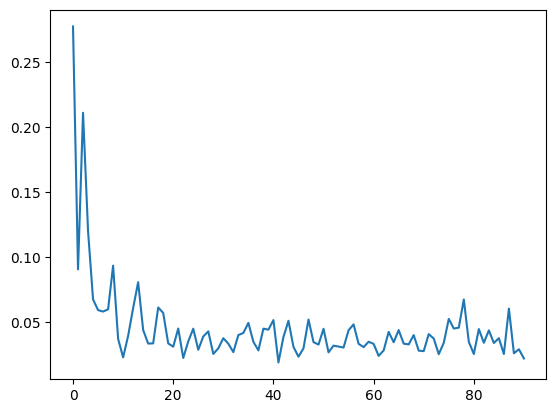

In [10]:
import matplotlib.pyplot as plt

plt.plot([x[0] for x in critic_loss])

[1.53059616e+02 1.52872238e+02 1.52513123e+02 1.52725494e+02
 1.54372467e+02 1.58294388e+02 1.82000008e+01 1.82000008e+01
 1.82000008e+01 1.82000008e+01 1.82000008e+01 0.00000000e+00
 1.28241135e-02 1.28241135e-02 1.28241135e-02 1.28241135e-02
 1.28241135e-02 1.28241135e-02]
Bolus injection!
[0.20039679 1.9996873  1.9999931 ]
Episode finished after 82 timesteps


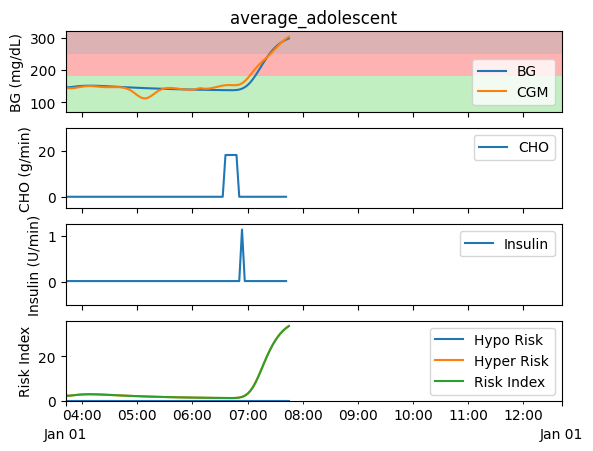

In [11]:
observation, info = env.reset()
last_meal = 0
for t in range(1000):
    env.render(mode='human')
    if last_meal > observation[11]:
        print(observation)
        action = agent.select_action(observation)
        print('Bolus injection!')
        print(action)
    else:
        action = [0, 0, 0]
    last_meal = observation[11]
    observation, reward, done, _, info = env.step(action)  
    # print('info  ', info)     
    # print('CHO   ', observation[11])
    print(f'Still alive {t}', end='\r')
    if done:         
        print("Episode finished after {} timesteps".format(t + 1))

        break